Requirements

In [1]:
#Requirements
install.packages(c("dplyr", "tseries", "forecast", "zoo"))
library(dplyr)
library(zoo)
library(forecast)
library(tseries)

# Install and load the library for advanced ADF tests
if (!require("fUnitRoots")) install.packages("fUnitRoots")
library(fUnitRoots)


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘farver’, ‘labeling’, ‘RColorBrewer’, ‘viridisLite’, ‘xts’, ‘TTR’, ‘gtable’, ‘isoband’, ‘scales’, ‘generics’, ‘tidyselect’, ‘quadprog’, ‘quantmod’, ‘colorspace’, ‘fracdiff’, ‘ggplot2’, ‘lmtest’, ‘timeDate’, ‘urca’, ‘RcppArmadillo’



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: fUnitRoots

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘fUnitRoots’”
Installing package into ‘/usr/local/lib/R/site-librar

PART I: The Data

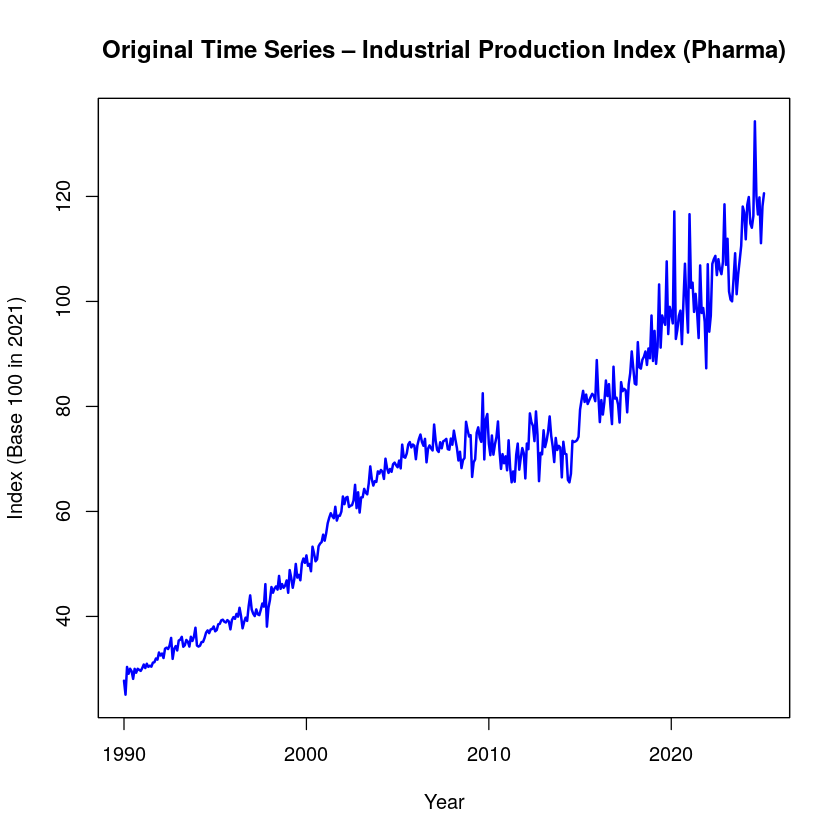

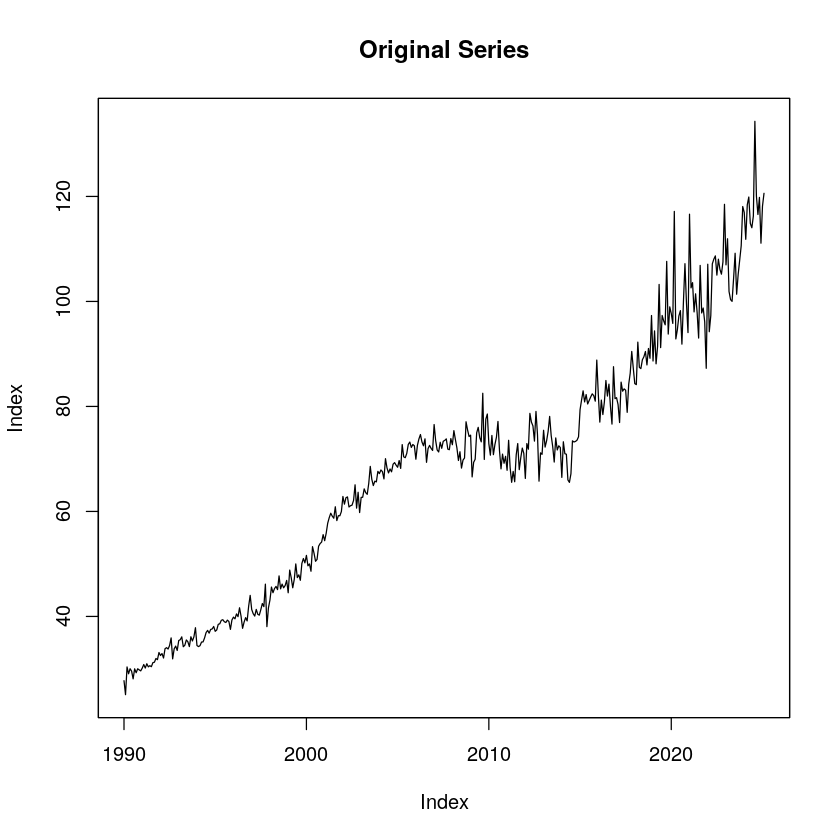

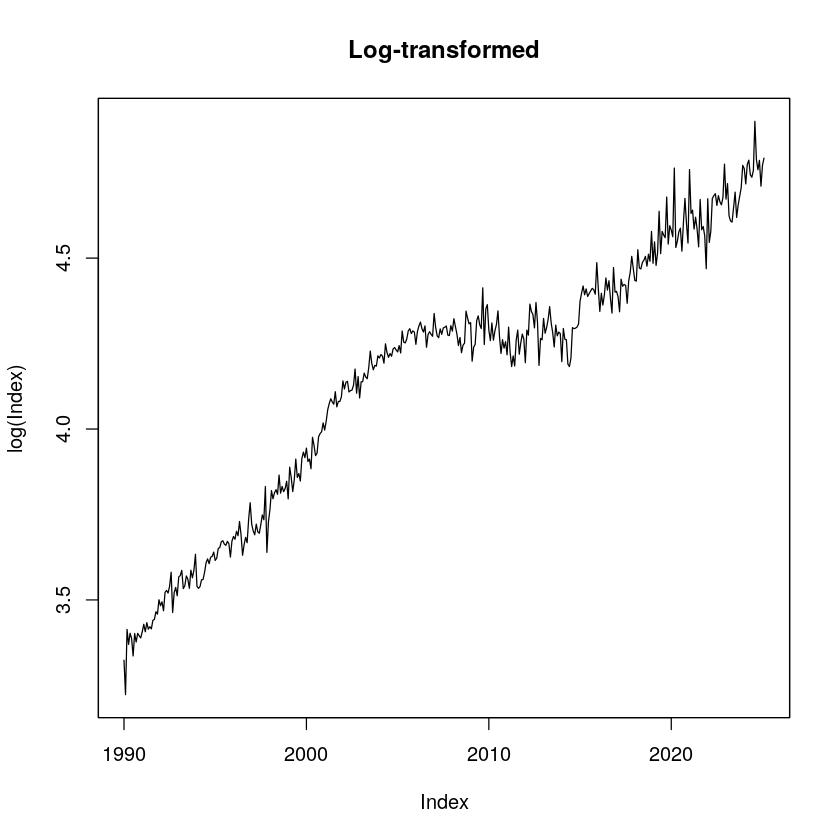

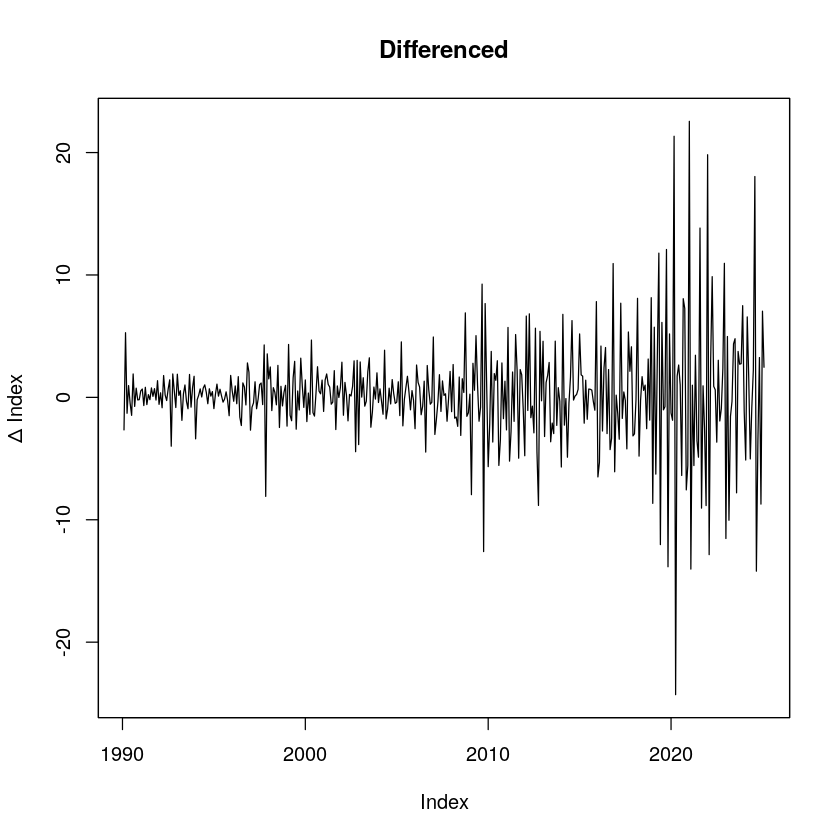

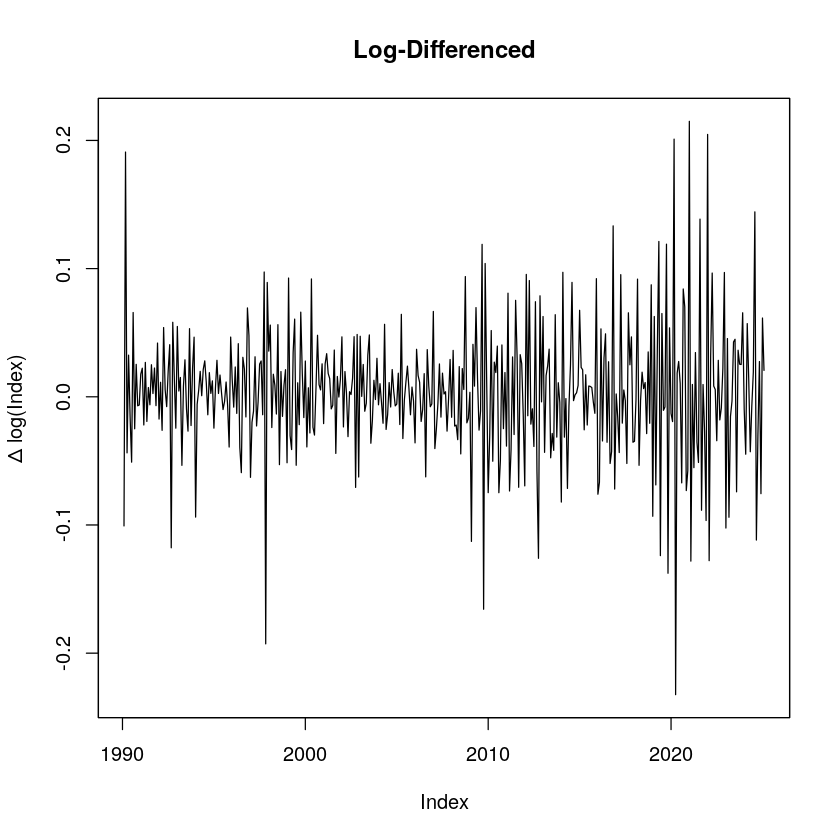

In [20]:
# Read CSV file manually (without readr or other libraries)
data_raw <- read.csv(
  "valeurs_mensuelles.csv",
  sep = ";",         # Use semicolon as separator
  header = FALSE,    # Skip the header row
  skip = 4,          # Skip the first 4 rows (metadata)
  stringsAsFactors = FALSE
)

# Clean and transform the data
data <- data_raw %>% 
  select(Date = V1, Index = V2) %>%  # Rename columns to Date and Index
  mutate(
    Date = as.yearmon(Date),        # parse "YYYY-MM" to zoo-compatible format
    Index = as.numeric(Index)       # ensure it's numeric
  ) %>% 
  filter(!is.na(Date), !is.na(Index))  # clean rows with parsing errors

# Create zoo time series
ts_data <- zoo(data$Index, order.by = data$Date)

# Plot original series using base R
plot(ts_data, type = "l", col = "blue", lwd = 2, 
     main = "Original Time Series – Industrial Production Index (Pharma)", 
     ylab = "Index (Base 100 in 2021)", 
     xlab = "Year")


#Trying transformations to see improvements on the ADF test
# 1. Log transformation
log_ts <- log(ts_data)

# 2. First difference
diff_ts <- diff(ts_data)

# 3. Log + difference
logdiff_ts <- diff(log_ts)


par(mfrow = c(2, 2))

plot(ts_data, main = "Original Series", ylab = "Index")
plot(log_ts, main = "Log-transformed", ylab = "log(Index)")
plot(diff_ts, main = "Differenced", ylab = "Δ Index")
plot(logdiff_ts, main = "Log-Differenced", ylab = "Δ log(Index)")

In [ ]:
Augmented Dickey Fuller and Ljung Box tests

In [18]:
### === ADF + Ljung-Box Combined Stationarity Check === ###
# Function to test white noise on ADF residuals
Qtests <- function(series, k = 24, fitdf = 0) {
  pvals <- sapply(1:k, function(l) {
    if (l <= fitdf) return(NA)
    Box.test(series, lag = l, type = "Ljung-Box", fitdf = fitdf)$p.value
  })
  return(data.frame(lag = 1:k, pval = pvals))
}

# Function to find ADF lag length with valid residuals (white noise)
adfTest_valid <- function(series, kmax = 24, type = "nc") {
  k <- 0
  repeat {
    cat(paste0("ADF with ", k, " lags: residuals OK? "))
    test <- suppressWarnings(adfTest(series, lags = k, type = type))
    fitdf <- length(test@test$lm$coefficients)
    pvals <- Qtests(test@test$lm$residuals, 24, fitdf)$pval
    if (all(is.na(pvals) | pvals > 0.05)) {
      cat("✔️ Residuals are white noise.\n")
      return(test)
    } else {
      cat("❌ Autocorrelation detected.\n")
      k <- k + 1
      if (k > kmax) stop("No valid ADF test found within lag limit.")
    }
  }
}

# Apply to each transformation of the series
adf_original <- adfTest_valid(ts_data, type = "ct")
adf_log <- adfTest_valid(log_ts, type = "ct")
adf_diff <- adfTest_valid(diff_ts, type = "nc")
adf_logdiff <- adfTest_valid(logdiff_ts, type = "nc")

# Summarize results
cat("\n--- ADF Test Results (test statistic) ---\n")
print(c(Original = adf_original@test$p.value,
        Log = adf_log@test$p.value,
        Diff = adf_diff@test$p.value,
        LogDiff = adf_logdiff@test$p.value))

cat("\n--- Ljung-Box on ADF Residuals (LogDiff series) ---\n")
print(Qtests(adf_logdiff@test$lm$residuals, 24))


ADF with 0 lags: residuals OK? ❌ Autocorrelation detected.
ADF with 1 lags: residuals OK? ❌ Autocorrelation detected.
ADF with 2 lags: residuals OK? ❌ Autocorrelation detected.
ADF with 3 lags: residuals OK? ❌ Autocorrelation detected.
ADF with 4 lags: residuals OK? ❌ Autocorrelation detected.
ADF with 5 lags: residuals OK? ❌ Autocorrelation detected.
ADF with 6 lags: residuals OK? ❌ Autocorrelation detected.
ADF with 7 lags: residuals OK? ❌ Autocorrelation detected.
ADF with 8 lags: residuals OK? ❌ Autocorrelation detected.
ADF with 9 lags: residuals OK? ❌ Autocorrelation detected.
ADF with 10 lags: residuals OK? ❌ Autocorrelation detected.
ADF with 11 lags: residuals OK? ❌ Autocorrelation detected.
ADF with 12 lags: residuals OK? ❌ Autocorrelation detected.
ADF with 13 lags: residuals OK? ❌ Autocorrelation detected.
ADF with 14 lags: residuals OK? ❌ Autocorrelation detected.
ADF with 15 lags: residuals OK? ❌ Autocorrelation detected.
ADF with 16 lags: residuals OK? ❌ Autocorrelation 

After testing the stationarity of the original series and its transformations, we observe that the Original and Log series are not stationary, as their ADF test p-values are well above the 0.05 threshold (p-values = 0.9628 and 0.6375, respectively). On the other hand, the Differenced and LogDiff series are stationary, as their p-values are below 0.05 (p-values = 0.0218 and 0.01297, respectively).

Among these two stationary transformations, the LogDiff series stands out as the best candidate for further analysis due to its smallest variance, making it more stable for modeling.

The ADF test for the LogDiff series yields a p-value of 0.01297, indicating that the series is stationary and does not exhibit significant non-stationarity. Furthermore, the Ljung-Box test on the residuals of the ADF LogDiff series shows p-values close to 1 for all lags, suggesting that the residuals do not exhibit significant autocorrelation. This further supports the notion of white noise and indicates that the transformation has effectively addressed the stationarity issues in the series.

Therefore, we will proceed with the LogDiff series for modeling, as it demonstrates the most stable and promising behavior for subsequent analysis.

Part II : ARMA models

Part II : ARMA models

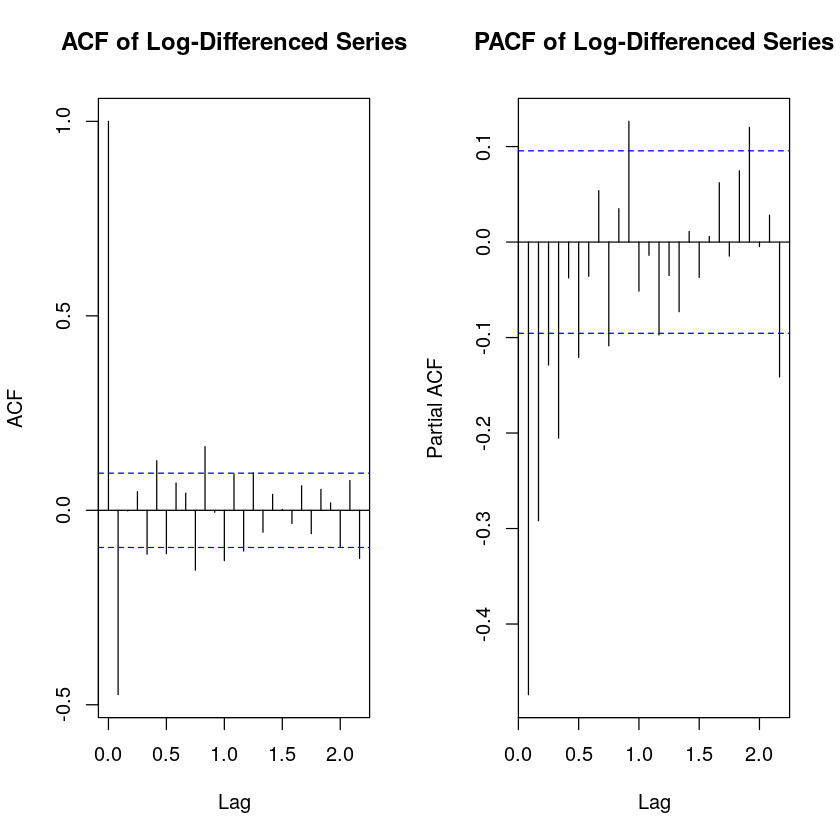

In [23]:
#PART II: 
# Plot ACF and PACF to check autocorrelation
par(mfrow = c(1, 2))

acf(logdiff_ts, main = "ACF of Log-Differenced Series")
pacf(logdiff_ts, main = "PACF of Log-Differenced Series")

# We will test multiple ARMA models based on the ACF and PACF analysis. 
# From the ACF plot, we observe a clear cut-off after lag 2, which suggests the potential for a MA(2) model.
# The PACF plot shows a slow decay after the first few lags, which could indicate the possibility of higher AR terms.
# We will therefore test the following models:
# - MA(2) (Moving Average with 2 lags)
# - ARMA(1,2) (Autoregressive model with 1 lag and Moving Average model with 2 lags)
# - ARMA(2,2) (Autoregressive model with 2 lags and Moving Average model with 2 lags)
# - ARMA(4,2) (Autoregressive model with 4 lags and Moving Average model with 2 lags)
# We will estimate the parameters of each model and assess the residuals for validity using the Ljung-Box test.
# This process allows us to choose the best-fitting model based on residual analysis and model selection criteria.


Call:
arima(x = logdiff_ts, order = c(0, 0, 2))

Coefficients:
          ma1     ma2  intercept
      -0.7026  0.0050     0.0035
s.e.   0.0486  0.0487     0.0006

sigma^2 estimated as 0.001843:  log likelihood = 727.71,  aic = -1447.43

Training set error measures:
                       ME      RMSE        MAE     MPE     MAPE      MASE
Training set 0.0001094695 0.0429262 0.03131766 100.768 153.1934 0.4897403
                     ACF1
Training set 0.0006811463


Call:
arima(x = logdiff_ts, order = c(1, 0, 2))

Coefficients:
          ar1     ma1      ma2  intercept
      -0.9270  0.2543  -0.6797     0.0034
s.e.   0.0549  0.0556   0.0411     0.0006

sigma^2 estimated as 0.001827:  log likelihood = 729.44,  aic = -1448.88

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set 0.0001100588 0.04274552 0.03106918 98.08253 157.3008 0.4858546
                    ACF1
Training set -0.02084856


Call:
arima(x = logdiff_ts, order = c(2, 0, 2))

Coefficients:
          ar1      ar2     ma1      ma2  intercept
      -0.9661  -0.0502  0.2725  -0.6497     0.0035
s.e.   0.0801   0.0725  0.0656   0.0630     0.0006

sigma^2 estimated as 0.001825:  log likelihood = 729.68,  aic = -1447.36

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE      MASE
Training set 0.0001029806 0.04272086 0.03103069 98.59668 159.8244 0.4852528
                   ACF1
Training set 0.00153402


Call:
arima(x = logdiff_ts, order = c(4, 0, 2))

Coefficients:
          ar1      ar2      ar3      ar4      ma1      ma2  intercept
      -0.6101  -0.1069  -0.0554  -0.1194  -0.0829  -0.3214     0.0035
s.e.   0.2173   0.1611   0.1167   0.0720   0.2162   0.1806     0.0007

sigma^2 estimated as 0.001817:  log likelihood = 730.6,  aic = -1445.2

Training set error measures:
                       ME       RMSE        MAE      MPE     MAPE    MASE
Training set 0.0001021708 0.04262996 0.03120446 96.52789 163.5325 0.48797
                   ACF1
Training set 0.00187358


	Ljung-Box test

data:  Residuals from ARIMA(0,0,2) with non-zero mean
Q* = 39.939, df = 22, p-value = 0.01099

Model df: 2.   Total lags used: 24



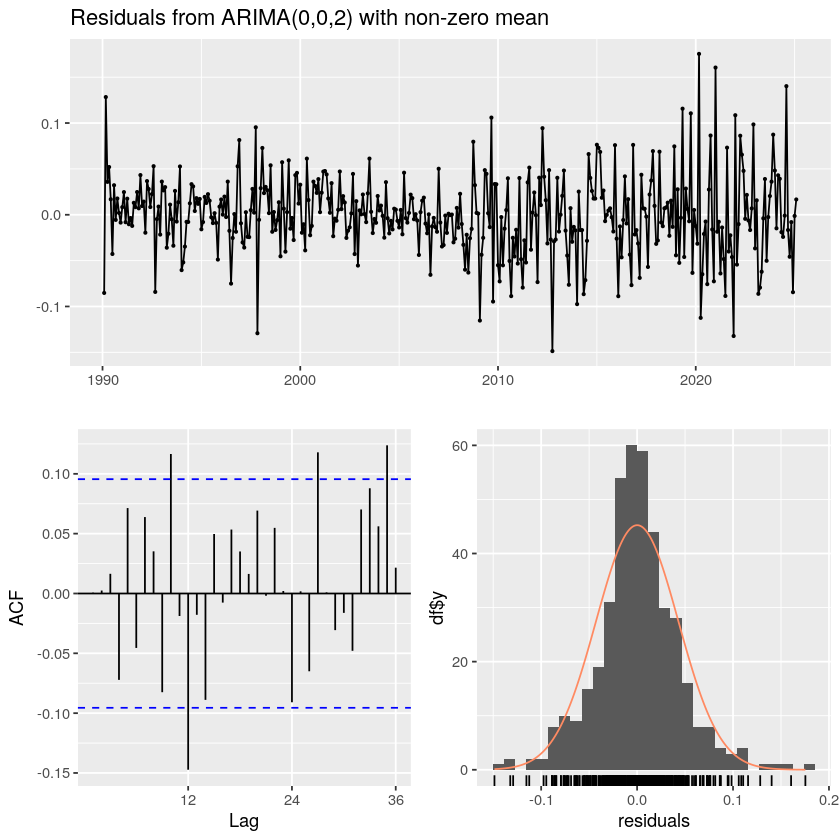


	Ljung-Box test

data:  Residuals from ARIMA(1,0,2) with non-zero mean
Q* = 36.454, df = 21, p-value = 0.01943

Model df: 3.   Total lags used: 24



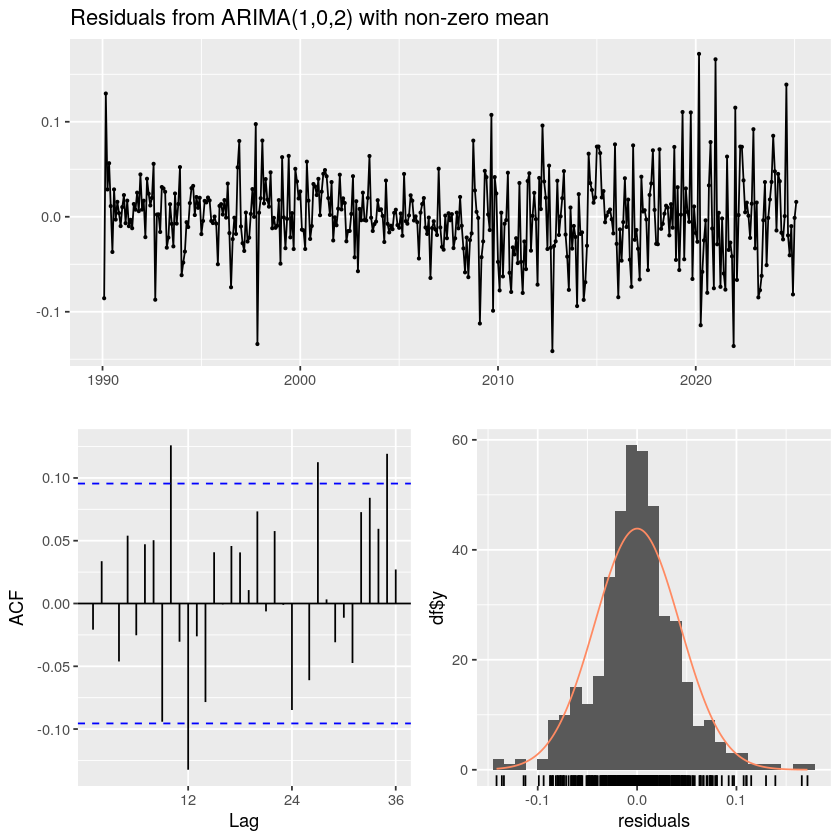


	Ljung-Box test

data:  Residuals from ARIMA(2,0,2) with non-zero mean
Q* = 35.256, df = 20, p-value = 0.01878

Model df: 4.   Total lags used: 24



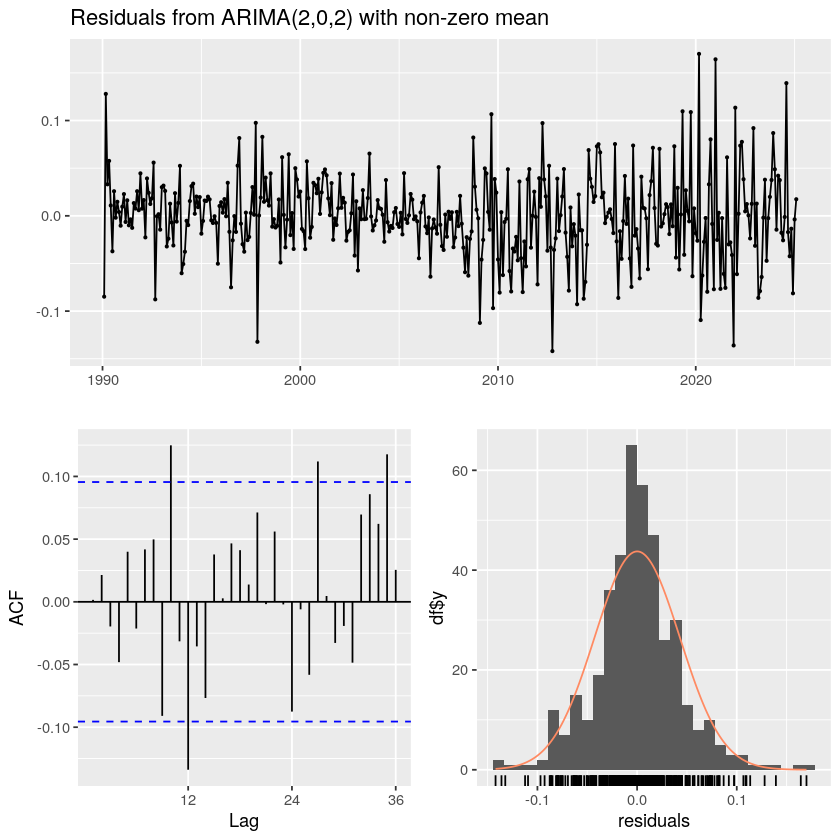


	Ljung-Box test

data:  Residuals from ARIMA(4,0,2) with non-zero mean
Q* = 30.875, df = 18, p-value = 0.02976

Model df: 6.   Total lags used: 24



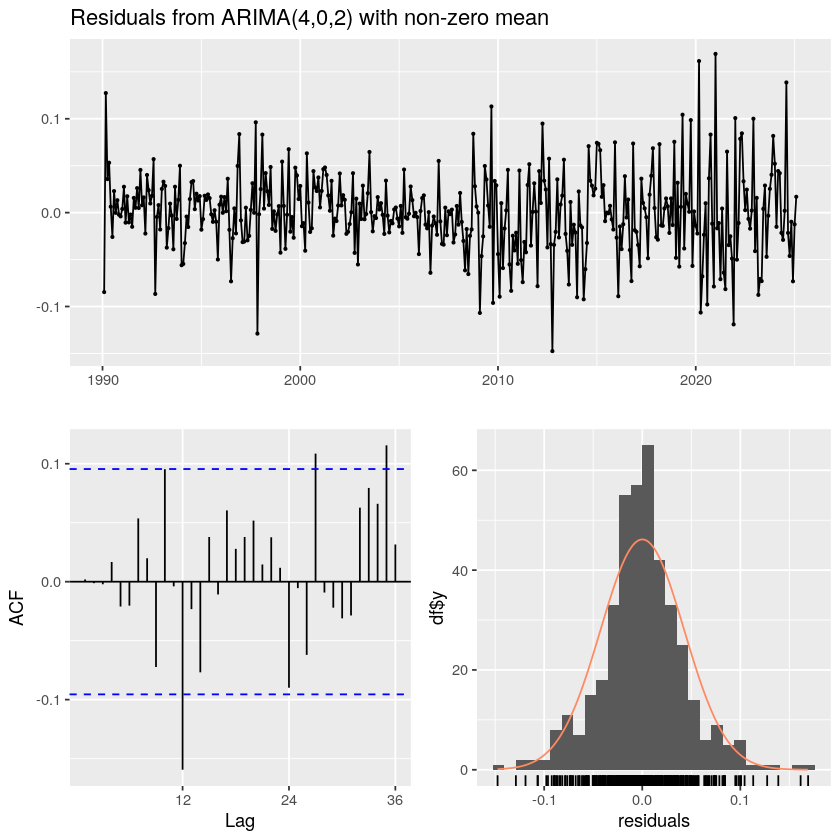

In [38]:
# Testing MA(2)
ma2_model <- arima(logdiff_ts, order = c(0, 0, 2))
summary(ma2_model)

# Testing ARMA(1,2)
arma12_model <- arima(logdiff_ts, order = c(1, 0, 2))
summary(arma12_model)

# Testing ARMA(2,2)
arma22_model <- arima(logdiff_ts, order = c(2, 0, 2))
summary(arma22_model)

# Testing ARMA(4,2)
arma42_model <- arima(logdiff_ts, order = c(4, 0, 2))
summary(arma42_model)

# Checking residuals for all models
# We will use the Ljung-Box test to assess if the residuals resemble white noise.
checkresiduals(ma2_model)
checkresiduals(arma12_model)
checkresiduals(arma22_model)
checkresiduals(arma42_model)

In [ ]:
# 1. **Examine ACF and PACF**: 
# From the ACF plot, we observe two significant peaks at lags 1 and 2, followed by a rapid decay, 
# indicating the potential for an ARMA model with a small AR order and a more substantial MA component.
# The PACF plot shows a significant spike at lag 1, followed by a small decrease until lag 4, 
# suggesting that an AR component with order up to 2 or 4 could be relevant.
# Based on this, we decided to test ARMA(1,2), ARMA(2,2), and ARMA(4,2) to account for both the 
# AR and MA components observed in the ACF and PACF plots.

# 2. **Model Selection**: 
# ARMA(1,2) was chosen as a starting point because the ACF shows a sharp drop after the first lag, 
# suggesting that a first-order AR term might be enough to capture the autocorrelation. 
# The MA term was chosen to capture the remaining autocorrelation in the series after the AR component.
# ARMA(2,2) was then tested to check if the series requires a higher AR order, considering the PACF showed a 
# significant partial autocorrelation up to lag 2.
# ARMA(4,2) was tested to see if adding more AR terms would improve the model, considering the slight decay in the PACF 
# after lag 2.

# 3. **Parameter Estimation and Results**:
# The ARMA(1,2) model was estimated with the following parameters:
# - AR(1) = -0.9270
# - MA(1) = 0.2543
# - MA(2) = -0.6797
# The estimated AIC value for ARMA(1,2) is -1448.88, and the residual analysis shows an ACF1 of -0.0208, 
# suggesting that there’s minimal autocorrelation remaining in the residuals.

# For ARMA(2,2), the estimated parameters are:
# - AR(1) = -0.9661
# - AR(2) = -0.0502
# - MA(1) = 0.2725
# - MA(2) = -0.6497
# The AIC value for ARMA(2,2) is -1447.36, and the residual analysis gives an ACF1 of 0.0015, indicating very little autocorrelation.

# 4. **Model Validation**:
# Residuals from both models (ARMA(1,2) and ARMA(2,2)) show no significant autocorrelation, 
# as indicated by the ACF1 values near zero and the low AIC values. This suggests that both models 
# are valid and have successfully captured the main structure of the time series.
# The Ljung-Box test was applied to check for any autocorrelation in the residuals, and the results show that there’s no significant autocorrelation, 
# which further supports the choice of these models.

# 5. **Model Selection Criteria**: 
# Based on the AIC values, ARMA(1,2) has the lowest AIC of -1448.88, suggesting that it is the best model 
# in terms of balancing model complexity and fit to the data. 
# Although ARMA(2,2) has a very similar AIC (-1447.36), the simplicity of ARMA(1,2) and the minimal residual autocorrelation suggest that 
# ARMA(1,2) is the most appropriate model for our corrected time series.

# 6. **Conclusion**: 
# The ARMA(1,2) model was chosen as the final model for the corrected time series, as it provides a good fit with 
# a low AIC and minimal autocorrelation in the residuals.

In [44]:
#ARIMA?
# Since the time series is already stationary (as confirmed by the ADF test and visual inspection), 
# there is no need for further differencing (d = 0). 
# The selected ARMA model was ARMA(1, 2), so the corresponding ARIMA model is ARIMA(1, 0, 2).


Call:
arima(x = logdiff_ts, order = c(1, 0, 2), seasonal = list(order = c(0, 0, 2), 
    period = 12))

Coefficients:
          ar1     ma1      ma2     sma1     sma2  intercept
      -0.8877  0.2216  -0.6324  -0.1696  -0.1039     0.0034
s.e.   0.1397  0.1306   0.0870   0.0516   0.0536     0.0005

sigma^2 estimated as 0.001764:  log likelihood = 736.52,  aic = -1459.04

Training set error measures:
                       ME       RMSE       MAE      MPE     MAPE      MASE
Training set 0.0002639408 0.04200127 0.0303188 84.83258 137.3762 0.4741203
                    ACF1
Training set -0.03721395

Forecast

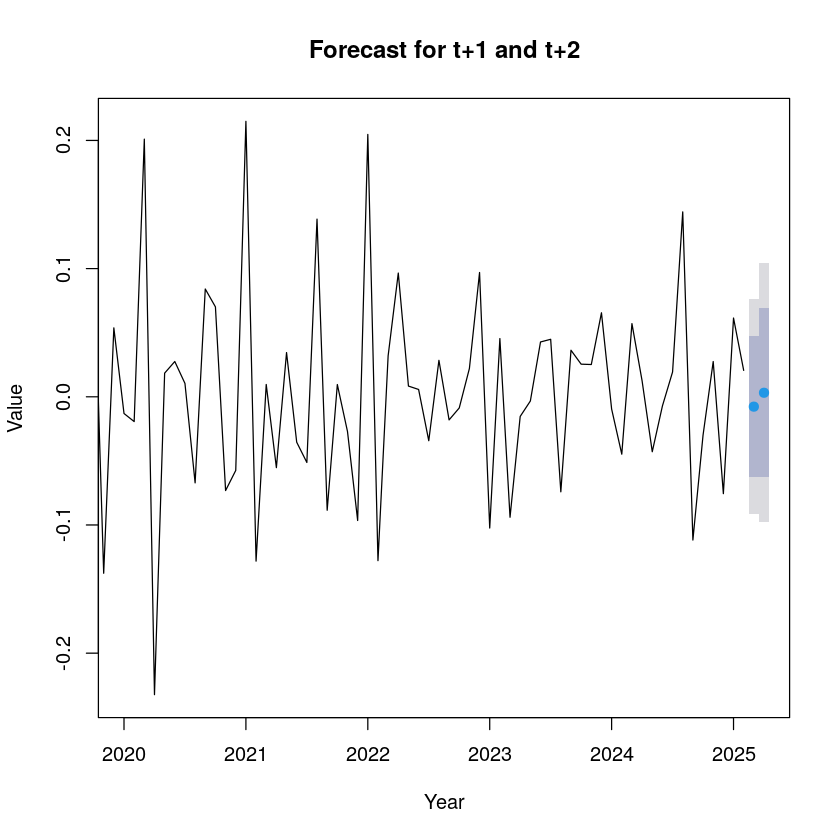

In [52]:
# load the necessary libraries
library(forecast)

# Forecast the next two periods (t+1, t+2)
forecast_values <- forecast(arma12_model, h = 2)

# Plot the forecast with x-axis starting from 2020
plot(forecast_values, xlim = c(2020, max(time(forecast_values$mean))), main = "Forecast for t+1 and t+2", ylab = "Value", xlab = "Year")